# Location Set Covering Problem (LSCP)

*Authors:* [Germano Barcelos](https://github.com/gegen07), [James Gaboardi](https://github.com/jGaboardi), [Levi J. Wolf](https://github.com/ljwolf), [Qunshan Zhao](https://github.com/qszhao)

Location Set Covering is a problem realized by Toregas, et al. (1971). He figured out that emergency services must have placed according to a response time, since, there is a allowable maximum service time when it's discussed how handle an emergency activity. Therefore he proprosed a model named LSCP that:

_Minimize the number of facilities needed and locate them so that every demand area is covered within a predefined maximal service distance or time._ Church L., Murray, A. (2018)

**LSCP can be written as:**

$i =$ index referencing nodes of the network as demand
<br>
$j =$ index referencing nodes of the network as potential facility sites
<br>
$S =$ maximal acceptable service distance or time standard
<br>
$d_{ij}=$ shortest distance or travel time between nodes $i$ and $j$
<br>
$N_i = \{j | d_{ij} < S\}$
<br>
$x_j = \begin{cases} 
              1, \text{if a facility is located at node} j\\
              0, \text{otherwise}
           \end{cases}$

$$ Minimize \sum_{j=1}^{n}{x_j} \\
Subject\;to: \sum_{j\in N_i}{x_j} \geq 1 \forall i \\
            x_j \in {0,1} \forall j \\ $$
_This excerpt above was quoted from Church L., Murray, A. (2018)_

This tutorial solves LSCP using `spopt.locate.coverage.LSCP` instance that depends on a array 2D representing the costs between facilities candidate sites and demand points. For that it uses a lattice 10x10 with simulated points to calculate the costs.

In [2]:
from spopt.locate.coverage import LSCP

import numpy
import geopandas
import pulp
import spaghetti
from shapely.geometry import Point

Since the model needs a distance cost matrix we should define some variables. In the comments, it's defined what these variables are for but solver. The solver, assigned below as `pulp.PULP_CBC_CMD`, is an interface to optimization solver developed by [COIN-OR](https://github.com/coin-or/Cbc). If you want to use another optimization interface as Gurobi or CPLEX see this [guide](https://coin-or.github.io/pulp/guides/how_to_configure_solvers.html) that explains how to achieve this.

In [3]:
CLIENT_COUNT = 100 # quantity demand points
FACILITY_COUNT = 5 # quantity supply points

MAX_COVERAGE = 8 # maximum service radius in meters

# Random seeds for reproducibility
CLIENT_SEED = 5 
FACILITY_SEED = 6 

solver = pulp.PULP_CBC_CMD()

## Lattice 10x10

Create lattice 10x10 with 9 vertical lines in interior.

In [5]:
lattice = spaghetti.regular_lattice((0, 0, 10, 10), 9, exterior=True)
ntw = spaghetti.Network(in_data=lattice)

Transform spaghetti instance into geodataframe.

In [8]:
gdf = spaghetti.element_as_gdf(ntw, arcs=True)

street = geopandas.GeoDataFrame(
    geopandas.GeoSeries(gdf["geometry"].buffer(0.2).unary_union),
    crs=gdf.crs,
    columns=["geometry"],
)

Plotting the network created by spaghetti we can verify that it seems a district with quarters and streets.

<AxesSubplot:>

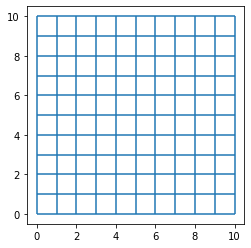

In [9]:
gdf.plot()

## Simulate points in a network

This function simulates points inside a network. In this case, it uses a lattice network 10x10 created by using spaghetti package. 

In [31]:
def simulated_geo_points(in_data, needed=20, seed=0):
    geoms = in_data.geometry
    area = tuple(in_data.total_bounds) # create a polygon with bounds to represent an area
    simulated_points_list = []
    simulated_points_all = False
    numpy.random.seed(seed)
    while simulated_points_all == False:
        x = numpy.random.uniform(area[0], area[2], 1) # get coordinates x of area variable
        y = numpy.random.uniform(area[1], area[3], 1) # get coordinates y of area variable
        point = Point(x, y) # transform coordinates x, y into `shapely.geometry.Point`
        if geoms.intersects(point)[0]: # check if the point belong to the network
            simulated_points_list.append(point)
        if len(simulated_points_list) == needed: # check if the length of array of points simulated 
                                                 # contains the number of points needed
            simulated_points_all = True
    sim_pts = geopandas.GeoDataFrame(
        simulated_points_list, columns=["geometry"], crs=in_data.crs
    ) # transform the points array into geodataframe

    return sim_pts

Below we use the function defined above and simulate the points inside lattice bounds.

In [32]:
client_points = simulated_geo_points(street, needed=CLIENT_COUNT, seed=CLIENT_SEED)
facility_points = simulated_geo_points(
    street, needed=FACILITY_COUNT, seed=FACILITY_SEED
)

Plotting the 100 client points we can see that the function generates dummy points to an area of 10x10 which is the area created by our lattice created previous cells.

<AxesSubplot:>

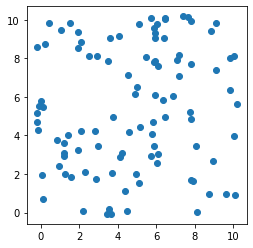

In [14]:
client_points.plot()

The plot of 5 facility points shows the same behavior. There are spread points in a 10x10 lattice.

<AxesSubplot:>

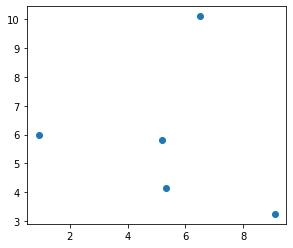

In [15]:
facility_points.plot()

## Transform simulated points to real points

To use cost matrix or geodataframes we have to pay attention in some details. The client and facility points simulated don't belong to network, so if we calculate the distances now we are supposed to receive a wrong result. Before calculating distances we snap points to the networok and then calculate the distances.

Below we snap points that is not spatially belong to network and create new real points geodataframes

In [18]:
ntw.snapobservations(client_points, "clients", attribute=True)
clients_snapped = spaghetti.element_as_gdf(
    ntw, pp_name="clients", snapped=True
)

ntw.snapobservations(facility_points, "facilities", attribute=True)
facilities_snapped = spaghetti.element_as_gdf(
    ntw, pp_name="facilities", snapped=True
)


Now the plot seems more organized as the points belong to network

<AxesSubplot:>

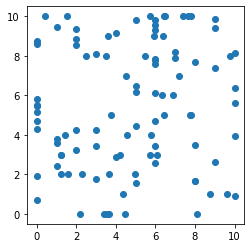

In [29]:
clients_snapped.plot()

<AxesSubplot:>

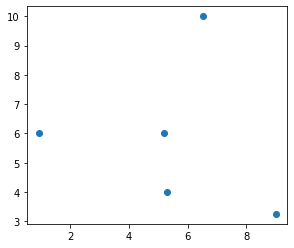

In [30]:
facilities_snapped.plot()

## Calculating the cost matrix 

Calculate distance between clients and facilities.

In [19]:
cost_matrix = ntw.allneighbordistances(
    sourcepattern=ntw.pointpatterns["clients"],
    destpattern=ntw.pointpatterns["facilities"],
)

The expected result here is a Dijkstra distance between clients and facilities points, so we our case an array 2D 100x5.

In [20]:
cost_matrix

array([[12.60302601,  3.93598651,  8.16571655,  6.04319467,  5.65607701],
       [13.10096347,  4.43392397,  8.66365401,  6.54113213,  5.15813955],
       [ 6.9095462 ,  4.2425067 ,  2.47223674,  0.34971486,  5.34955682],
       [ 2.98196832,  7.84581224,  3.45534114,  3.57786302,  6.25374871],
       [ 7.5002892 ,  6.32806975,  4.55779979,  6.43527791, 11.75939222],
       [ 0.60209077, 11.42987132,  5.03940023,  7.16192211,  9.8378078 ],
       [ 5.37335867,  6.20113923,  2.43086927,  4.30834738,  9.6324617 ],
       [ 5.40801577,  5.41976478,  3.02929369,  1.15181557,  4.85108725],
       [ 3.68807115,  8.51585171,  2.12538061,  4.24790249,  7.94717417],
       [14.22503627,  4.60274429,  9.78772681,  7.66520493,  4.98931924],
       [10.32521229,  4.99225179,  7.38272288,  9.260201  , 14.58431531],
       [ 6.65436171,  7.98732222,  5.59685112,  3.719373  ,  2.58135531],
       [11.55510375,  1.11193575,  7.11779429,  5.37988496, 10.70399927],
       [10.90832519,  1.75871431,  6.4

With ``LSCP.from_cost_matrix`` we model LSC problem to cover all demand points with $p$ facility points within `max_coverage` meters as service radius using cost matrix calculated previously.

In [25]:
lscp = LSCP.from_cost_matrix(cost_matrix, MAX_COVERAGE)
result = lscp.solve(solver)

Expected result is an instance of LSCP.

In [26]:
result

## Using GeoDataFrame

With ``LSCP.from_geodataframe`` we model the LSC problem to cover all demand points with $p$ facility points within `max_coverage` meters as service radius using geodataframes without calculating the cost matrix previously.

In [27]:
lscp = LSCP.from_geodataframe(
    clients_snapped, facilities_snapped, "geometry", "geometry", MAX_COVERAGE, distance_metric="euclidean"
)
result = lscp.solve(solver)

Expected result is an instance of LSCP.

In [28]:
result

## References

- [Location Covering Models - History, Applications, and Advancements - Ronald L. Church, Alan T. Murray](https://www.springer.com/gb/book/9783319998459)
- [The Location of Emergency Service Facilities - Constantine Toregas, Ralph Swain, Charles ReVelle, Lawrence Bergman](https://pubsonline.informs.org/doi/abs/10.1287/opre.19.6.1363)